<a href="https://colab.research.google.com/github/dcpatton/TimeSeries/blob/master/madrid_wx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For a more advanced approach to forecasting with DNNs see
[MetNet](https://ai.googleblog.com/2020/03/a-neural-weather-model-for-eight-hour.html).

**TODO**: 

1. More features for multivariate
2. Train on 3 years of data
3. Create a validation split after creating the windows and shuffling.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import random
seed = 52
tf.random.set_seed(seed)
random.seed(seed)

window_size = 366
batch_size = 32

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Retrieve and Load the Data

In [2]:
from google.colab import files
uploaded = files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
#!pip install kaggle -U

In [4]:
# !kaggle datasets list -s Madrid
!kaggle datasets download -d juliansimon/weather_madrid_lemd_1997_2015.csv --unzip

  0% 0.00/145k [00:00<?, ?B/s]
100% 145k/145k [00:00<00:00, 54.0MB/s]


In [5]:
df = pd.read_csv('/content/weather_madrid_LEMD_1997_2015.csv', parse_dates={'Date':[0]})
df.shape

(6812, 23)

In [6]:
df.head()

,Date,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,1997-01-01,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,NaN,229
1,1997-01-02,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.0,5.0,Rain,143
2,1997-01-03,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,NaN,0.0,6.0,Rain-Snow,256
3,1997-01-04,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.0,2.0,NaN,284
4,1997-01-05,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,NaN,0.0,7.0,Snow,2


In [7]:
start_date = df.head(1)['Date'][0]
end_date = df.tail(1)['Date'][len(df)-1]
missing_dates = pd.date_range(start=start_date, end=end_date).difference(df['Date'])
len(missing_dates)

127

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Max TemperatureC,6810.0,21.039648,8.867187,0.0,13.0,20.0,29.00,41.0
Mean TemperatureC,6809.0,14.658687,7.580461,-3.0,8.0,14.0,21.00,32.0
Min TemperatureC,6810.0,8.640529,6.837626,-10.0,3.0,9.0,14.00,28.0
Dew PointC,6810.0,8.120705,4.741067,-12.0,5.0,8.0,12.00,20.0
MeanDew PointC,6810.0,4.976211,4.654270,-15.0,2.0,6.0,8.00,16.0
Min DewpointC,6810.0,1.451248,4.909705,-22.0,-2.0,2.0,5.00,14.0
Max Humidity,6810.0,81.139354,17.531839,16.0,68.0,87.0,94.00,100.0
Mean Humidity,6810.0,57.971366,19.675744,15.0,41.0,59.0,74.00,100.0
Min Humidity,6810.0,34.729369,19.320359,4.0,19.0,32.0,47.75,100.0
Max Sea Level PressurehPa,6812.0,1020.529360,6.235941,994.0,1017.0,1020.0,1024.00,1047.0


In [9]:
missing_MeanTemp = df.loc[df['Mean TemperatureC'].isna()]
missing_MeanTemp

,Date,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
1240,2000-08-22,27.0,NaN,27.0,-1.0,-1.0,-1.0,16.0,16.0,16.0,1015,1015,1015,NaN,NaN,NaN,19,19,NaN,0.0,NaN,NaN,260
1539,2001-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1021,1019,1018,NaN,NaN,NaN,26,14,NaN,0.0,NaN,NaN,231
1540,2001-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1021,1019,1016,NaN,NaN,NaN,26,11,NaN,0.0,NaN,NaN,248


# Clean the data

Note that the counts for many columns are not at 6812.

In [10]:
last_missing_datetime = missing_dates[-1:].values[0]
last_missing_datetime

numpy.datetime64('2004-01-31T00:00:00.000000000')

In [11]:
original_df = df.copy(deep=True)

I will only use continuous data (no missing days). This also removes the three dates with missing temperatures since they were in 2000 and 2001.

In [12]:
df = df[df['Date'] > '2004-01-31'].reset_index(drop=True)

In [13]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Max TemperatureC,4352.0,21.250689,8.982573,0.0,14.00,21.0,29.0,41.0
Mean TemperatureC,4352.0,14.790441,7.707400,-3.0,8.00,14.0,22.0,31.0
Min TemperatureC,4352.0,8.641544,6.960585,-10.0,3.00,9.0,14.0,26.0
Dew PointC,4352.0,7.861903,4.824524,-12.0,5.00,8.0,11.0,20.0
MeanDew PointC,4352.0,4.671415,4.730477,-15.0,2.00,5.0,8.0,16.0
Min DewpointC,4352.0,1.053079,4.964288,-22.0,-2.00,1.0,4.0,14.0
Max Humidity,4352.0,80.089844,17.970109,26.0,66.00,86.0,94.0,100.0
Mean Humidity,4352.0,56.518382,19.915857,15.0,39.00,57.0,73.0,99.0
Min Humidity,4352.0,32.469899,19.211592,4.0,16.00,29.0,45.0,93.0
Max Sea Level PressurehPa,4352.0,1020.367417,6.364322,994.0,1017.00,1020.0,1024.0,1047.0


# Preprocess data

We are going to use the last 3 years as test data.

In [14]:
split_index = df[df['Date'] == '2013-01-01'].index[0]

In [15]:
# drop features we are not considering
df.drop(['Date', 'Max TemperatureC', 'Min TemperatureC',
       'Dew PointC', 'MeanDew PointC', 'Min DewpointC', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressurehPa',
       ' Mean Sea Level PressurehPa', ' Min Sea Level PressurehPa',
       ' Max VisibilityKm', ' Mean VisibilityKm', ' Min VisibilitykM',
       ' Max Wind SpeedKm/h', ' Mean Wind SpeedKm/h', ' Max Gust SpeedKm/h',
       'Precipitationmm', ' CloudCover', ' Events', 'WindDirDegrees'], axis='columns', inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mean TemperatureC  4352 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


split training, validation, and test data (last 3 years)

In [17]:
from sklearn.model_selection import train_test_split

train_df = df[:split_index]
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=False)
test_df = df[split_index:]

In [18]:
# #Normalize
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [19]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

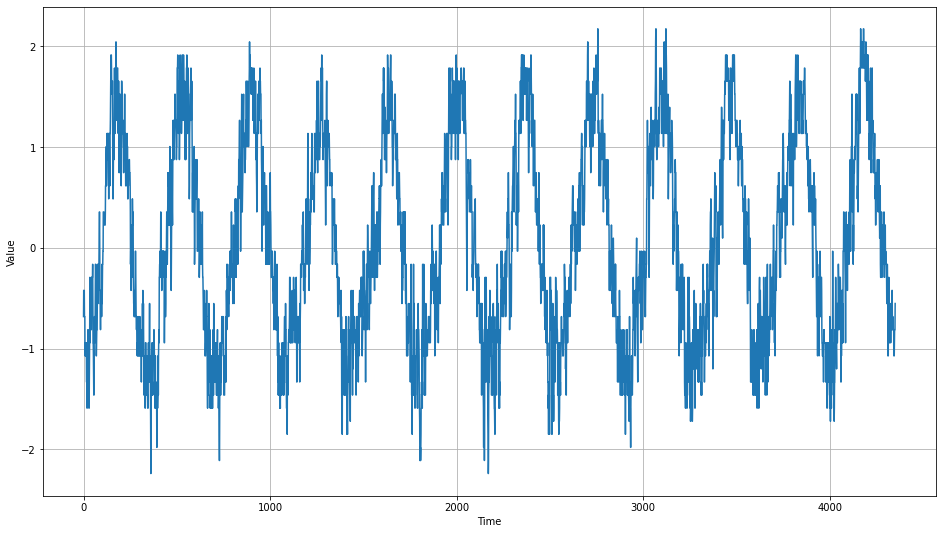

In [20]:
series_df = df
series_df = (series_df - train_mean) / train_std
series = np.array(series_df['Mean TemperatureC'])
time = np.array(df.index)
plt.figure(figsize=(16, 9))
plot_series(time, series)

In [21]:
def get_dataset(series, window_size, batch_size, shuffle=False, cache=False):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.map(lambda window: (window[:-1], window[-1]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1024)
  ds = ds.batch(batch_size)
  if cache:
    ds = ds.cache()
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [22]:
x_train = np.array(train_df['Mean TemperatureC'])
train_ds = get_dataset(x_train, window_size, batch_size, shuffle=True)
x_val = np.array(val_df['Mean TemperatureC'])
val_ds = get_dataset(x_val, window_size, batch_size, shuffle=False, cache=True)
x_test = np.array(test_df['Mean TemperatureC'])
test_ds = get_dataset(x_test, window_size, batch_size, shuffle=False, cache=True)

y_true = x_test

# Baseline

model that just returns the current temperature as the prediction, predicting "No change"

In [23]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras import Model, Input

input1 = Input(shape=(window_size,))
out = Lambda(lambda x: x[:,-1])(input1)

model = Model(inputs=[input1], outputs=[out])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', 
              metrics=['mae'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 366)]             0         
_________________________________________________________________
lambda (Lambda)              (None,)                   0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [24]:
# model.load_weights('model.h5')
(mse, mae) = model.evaluate(test_ds)
print('mean squared error = ' + str(mse))
print('mean absolute error = ' + str(mae))

23/23 [==============================] - 0s 10ms/step - loss: 0.0704 - mae: 0.1940
mean squared error = 0.07044193148612976
mean absolute error = 0.1939721554517746


In [25]:
def unscale_series(s):
  return (s * train_std[0]) +  train_mean[0]

In [26]:
results = model.predict(test_ds)

m = tf.keras.metrics.MeanAbsoluteError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mae = m.result().numpy()

m = tf.keras.metrics.MeanSquaredError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mse = m.result().numpy()

In [27]:
report = pd.DataFrame(columns=['Model', 'MAE', 'MSE'])
report.loc[len(report)] = ['Baseline', mae, mse]

# DNN Model

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
random.seed(seed)

from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import Model, Input

input1 = Input(shape=(window_size,))
x = Dense(512, activation='swish')(input1)
x = Dropout(.5)(x)
x = Dense(256, activation='swish')(x)
x = Dropout(.5)(x)
x = Dense(128, activation='swish')(x)
x = Dropout(.5)(x)
x = Dense(64, activation='swish')(x)
x = Dropout(.5)(x)
out = Dense(1)(x)

model = Model(inputs=[input1], outputs=[out])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', 
              metrics=['mae'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 366)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               187904    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [29]:
filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

history = model.fit(train_ds, epochs=500, verbose=2, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/500
70/70 - 1s - loss: 0.7325 - mae: 0.6522 - val_loss: 0.1893 - val_mae: 0.3512
Epoch 2/500
70/70 - 1s - loss: 0.3774 - mae: 0.4882 - val_loss: 0.1622 - val_mae: 0.3280
Epoch 3/500
70/70 - 1s - loss: 0.3101 - mae: 0.4439 - val_loss: 0.1554 - val_mae: 0.3155
Epoch 4/500
70/70 - 1s - loss: 0.2803 - mae: 0.4270 - val_loss: 0.1433 - val_mae: 0.3085
Epoch 5/500
70/70 - 1s - loss: 0.2412 - mae: 0.3892 - val_loss: 0.1374 - val_mae: 0.3005
Epoch 6/500
70/70 - 1s - loss: 0.2307 - mae: 0.3802 - val_loss: 0.1282 - val_mae: 0.2871
Epoch 7/500
70/70 - 1s - loss: 0.2338 - mae: 0.3829 - val_loss: 0.1420 - val_mae: 0.2992
Epoch 8/500
70/70 - 1s - loss: 0.2063 - mae: 0.3639 - val_loss: 0.1444 - val_mae: 0.3029
Epoch 9/500
70/70 - 1s - loss: 0.1978 - mae: 0.3501 - val_loss: 0.1337 - val_mae: 0.2876
Epoch 10/500
70/70 - 1s - loss: 0.1880 - mae: 0.3453 - val_loss: 0.1254 - val_mae: 0.2838
Epoch 11/500
70/70 - 1s - loss: 0.1853 - mae: 0.3401 - val_loss: 0.1307 - val_mae: 0.2905
Epoch 12/500
70/70 

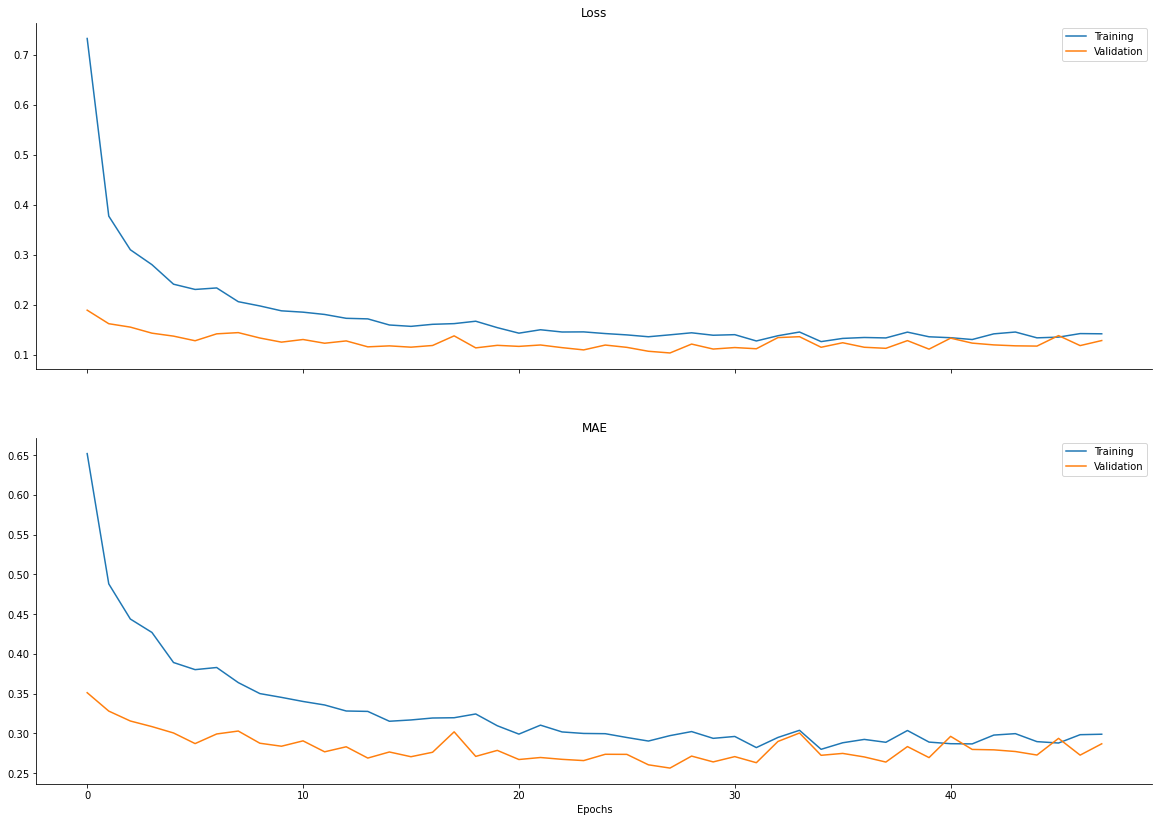

In [30]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [31]:
model.load_weights('model.h5')
(mse, mae) = model.evaluate(test_ds)
print('mean squared error = ' + str(mse))
print('mean absolute error = ' + str(mae))

23/23 [==============================] - 0s 2ms/step - loss: 0.0978 - mae: 0.2561
mean squared error = 0.09778057783842087
mean absolute error = 0.2560986280441284


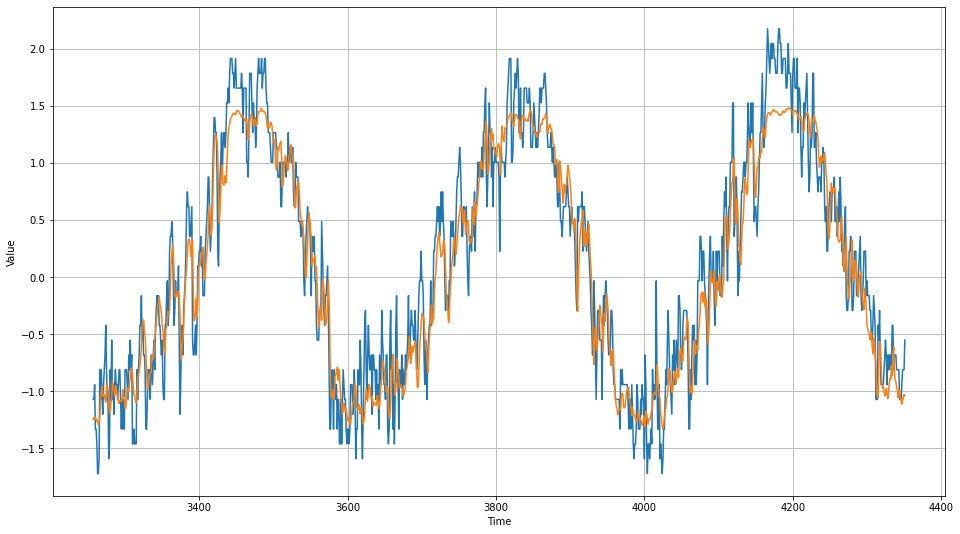

In [32]:
time_test = np.array(test_df.index)

forecast=[]
times = range(split_index-window_size, len(series)-window_size)
for time in times:
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(16, 9))

plot_series(time_test, x_test)
plot_series(time_test, results)

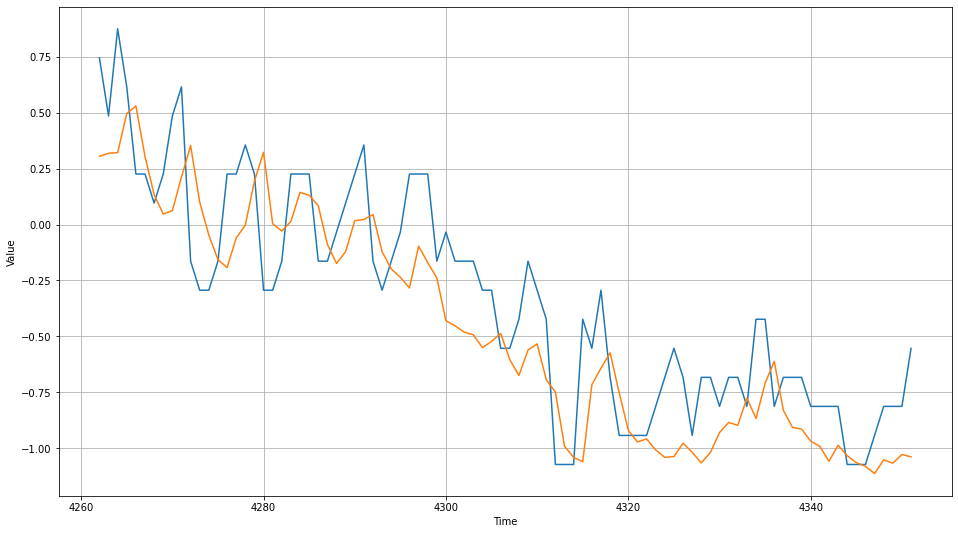

In [33]:
plt.figure(figsize=(16, 9))

plot_series(time_test[-90:], x_test[-90:])
plot_series(time_test[-90:], results[-90:])

In [34]:
results = model.predict(test_ds)

m = tf.keras.metrics.MeanAbsoluteError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mae = m.result().numpy()

m = tf.keras.metrics.MeanSquaredError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mse = m.result().numpy()

report.loc[len(report)] = ['DNN', mae, mse]

# SimpleRNN Model

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
random.seed(seed)

from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import Model

input1 = Input(shape=[window_size,1])
x = SimpleRNN(64)(input1)
x = Dense(64, activation='swish')(x)
out = Dense(1)(x)

model = Model(inputs=[input1], outputs=[out])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', 
              metrics=['mae'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 366, 1)]          0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                4224      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 8,449
Trainable params: 8,449
Non-trainable params: 0
_________________________________________________________________


In [36]:
filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

history = model.fit(train_ds, epochs=500, verbose=2, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/500
70/70 - 14s - loss: 0.1131 - mae: 0.2577 - val_loss: 0.0821 - val_mae: 0.2281
Epoch 2/500
70/70 - 15s - loss: 0.0685 - mae: 0.2040 - val_loss: 0.0746 - val_mae: 0.2145
Epoch 3/500
70/70 - 14s - loss: 0.0665 - mae: 0.2011 - val_loss: 0.0754 - val_mae: 0.2150
Epoch 4/500
70/70 - 14s - loss: 0.0672 - mae: 0.2022 - val_loss: 0.0712 - val_mae: 0.2083
Epoch 5/500
70/70 - 14s - loss: 0.0648 - mae: 0.1971 - val_loss: 0.0674 - val_mae: 0.2031
Epoch 6/500
70/70 - 14s - loss: 0.0651 - mae: 0.1991 - val_loss: 0.0709 - val_mae: 0.2082
Epoch 7/500
70/70 - 14s - loss: 0.0661 - mae: 0.2012 - val_loss: 0.0686 - val_mae: 0.2061
Epoch 8/500
70/70 - 14s - loss: 0.0666 - mae: 0.2013 - val_loss: 0.0711 - val_mae: 0.2118
Epoch 9/500
70/70 - 14s - loss: 0.0644 - mae: 0.1968 - val_loss: 0.0701 - val_mae: 0.2103
Epoch 10/500
70/70 - 14s - loss: 0.0636 - mae: 0.1965 - val_loss: 0.0670 - val_mae: 0.2018
Epoch 11/500
70/70 - 14s - loss: 0.0646 - mae: 0.1980 - val_loss: 0.0756 - val_mae: 0.2141
Epoch 12

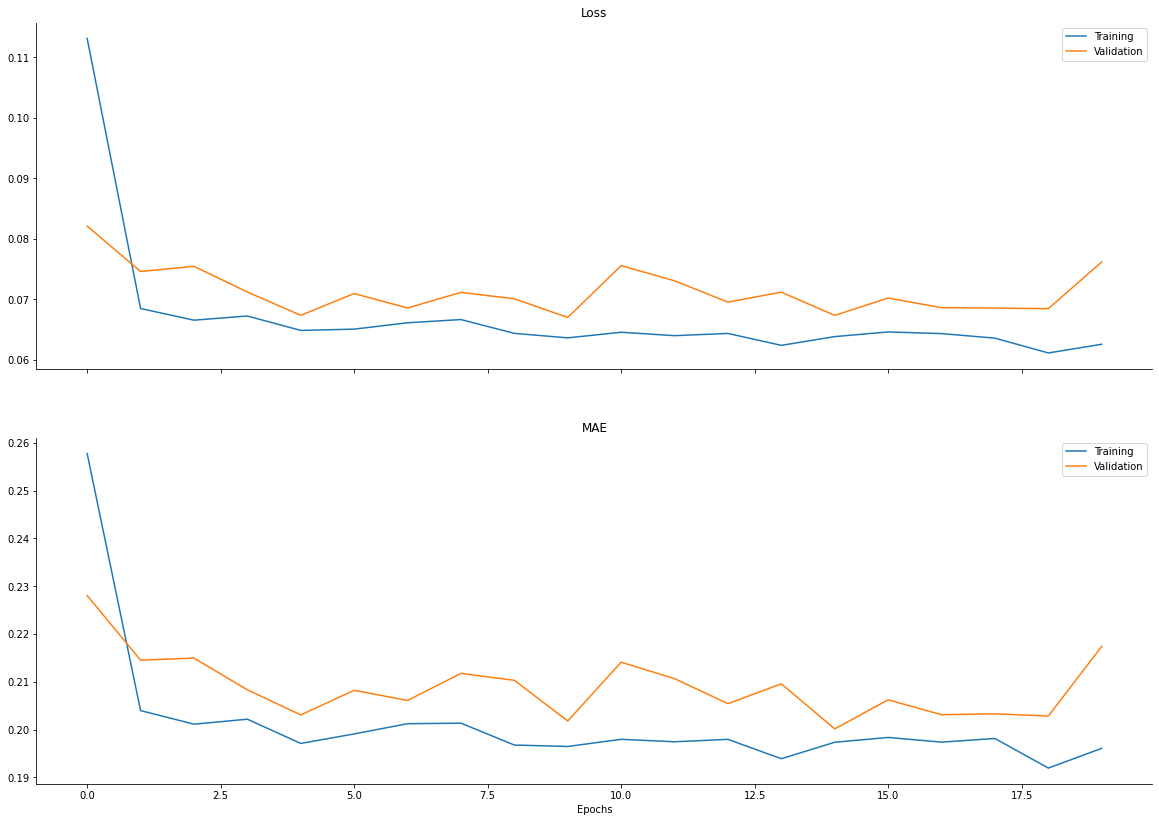

In [37]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [38]:
model.load_weights('model.h5')
(mse, mae) = model.evaluate(test_ds)
print('mean squared error = ' + str(mse))
print('mean absolute error = ' + str(mae))

results = model.predict(test_ds)

m = tf.keras.metrics.MeanAbsoluteError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mae = m.result().numpy()

m = tf.keras.metrics.MeanSquaredError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mse = m.result().numpy()

report.loc[len(report)] = ['SimpleRNN', mae, mse]

23/23 [==============================] - 1s 25ms/step - loss: 0.0676 - mae: 0.2027
mean squared error = 0.06756757944822311
mean absolute error = 0.20265574753284454


# GRU Model

In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
random.seed(seed)

from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras import Model

input1 = Input(shape=[window_size,1])
x = GRU(64)(input1)
x = Dense(64, activation='swish')(x)
out = Dense(1)(x)

model = Model(inputs=[input1], outputs=[out])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', 
              metrics=['mae'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 366, 1)]          0         
_________________________________________________________________
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 17,089
Trainable params: 17,089
Non-trainable params: 0
_________________________________________________________________


In [40]:
filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

history = model.fit(train_ds, epochs=500, verbose=2, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/500
70/70 - 1s - loss: 0.1942 - mae: 0.3244 - val_loss: 0.1001 - val_mae: 0.2472
Epoch 2/500
70/70 - 1s - loss: 0.0809 - mae: 0.2256 - val_loss: 0.0909 - val_mae: 0.2381
Epoch 3/500
70/70 - 1s - loss: 0.0754 - mae: 0.2159 - val_loss: 0.0817 - val_mae: 0.2261
Epoch 4/500
70/70 - 1s - loss: 0.0717 - mae: 0.2103 - val_loss: 0.0770 - val_mae: 0.2171
Epoch 5/500
70/70 - 1s - loss: 0.0694 - mae: 0.2051 - val_loss: 0.0728 - val_mae: 0.2102
Epoch 6/500
70/70 - 1s - loss: 0.0675 - mae: 0.2015 - val_loss: 0.0691 - val_mae: 0.2068
Epoch 7/500
70/70 - 1s - loss: 0.0670 - mae: 0.2003 - val_loss: 0.0684 - val_mae: 0.2064
Epoch 8/500
70/70 - 1s - loss: 0.0672 - mae: 0.2019 - val_loss: 0.0679 - val_mae: 0.2054
Epoch 9/500
70/70 - 1s - loss: 0.0672 - mae: 0.2020 - val_loss: 0.0674 - val_mae: 0.2034
Epoch 10/500
70/70 - 1s - loss: 0.0658 - mae: 0.1989 - val_loss: 0.0692 - val_mae: 0.2060
Epoch 11/500
70/70 - 1s - loss: 0.0661 - mae: 0.2003 - val_loss: 0.0694 - val_mae: 0.2092
Epoch 12/500
70/70 

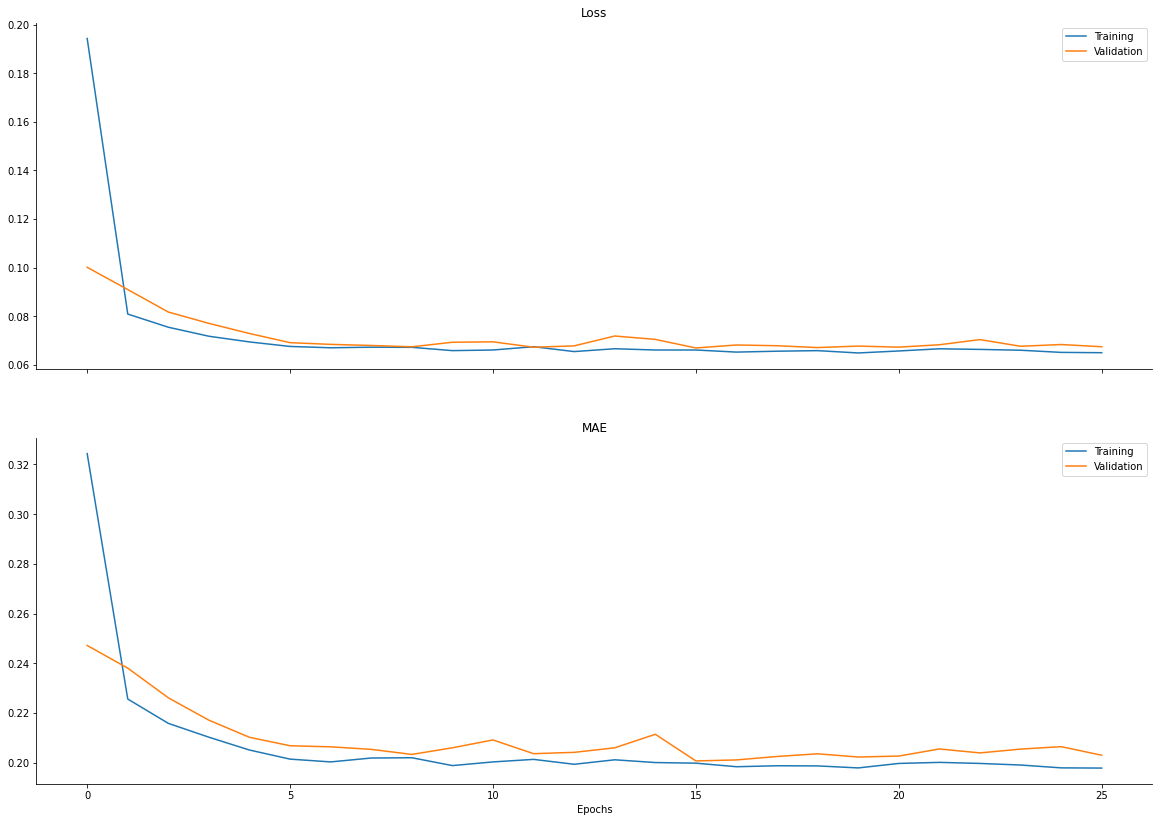

In [41]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [42]:
model.load_weights('model.h5')
(mse, mae) = model.evaluate(test_ds)
print('mean squared error = ' + str(mse))
print('mean absolute error = ' + str(mae))

results = model.predict(test_ds)

m = tf.keras.metrics.MeanAbsoluteError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mae = m.result().numpy()

m = tf.keras.metrics.MeanSquaredError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mse = m.result().numpy()

report.loc[len(report)] = ['GRU', mae, mse]

23/23 [==============================] - 0s 7ms/step - loss: 0.0642 - mae: 0.1953
mean squared error = 0.06420677900314331
mean absolute error = 0.19530969858169556


# LSTM Model

In [43]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
random.seed(seed)

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Model

input1 = Input(shape=[window_size,1])
x = LSTM(512, return_sequences=True)(input1)
x = LSTM(256)(x)
x = Dense(64, activation='swish')(x)
out = Dense(1)(x)

model = Model(inputs=[input1], outputs=[out])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', 
              metrics=['mae'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 366, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 366, 512)          1052672   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,856,641
Trainable params: 1,856,641
Non-trainable params: 0
_________________________________________________________________


In [44]:
filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

history = model.fit(train_ds, epochs=500, verbose=2, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/500
70/70 - 5s - loss: 0.1600 - mae: 0.3121 - val_loss: 0.1342 - val_mae: 0.2856
Epoch 2/500
70/70 - 4s - loss: 0.0971 - mae: 0.2485 - val_loss: 0.1018 - val_mae: 0.2499
Epoch 3/500
70/70 - 4s - loss: 0.0757 - mae: 0.2174 - val_loss: 0.0789 - val_mae: 0.2227
Epoch 4/500
70/70 - 4s - loss: 0.0703 - mae: 0.2076 - val_loss: 0.0694 - val_mae: 0.2060
Epoch 5/500
70/70 - 4s - loss: 0.0696 - mae: 0.2074 - val_loss: 0.0675 - val_mae: 0.2038
Epoch 6/500
70/70 - 4s - loss: 0.0676 - mae: 0.2037 - val_loss: 0.0669 - val_mae: 0.1987
Epoch 7/500
70/70 - 4s - loss: 0.0686 - mae: 0.2035 - val_loss: 0.0663 - val_mae: 0.2012
Epoch 8/500
70/70 - 4s - loss: 0.0667 - mae: 0.2016 - val_loss: 0.0676 - val_mae: 0.2014
Epoch 9/500
70/70 - 4s - loss: 0.0655 - mae: 0.1995 - val_loss: 0.0683 - val_mae: 0.2026
Epoch 10/500
70/70 - 4s - loss: 0.0679 - mae: 0.2030 - val_loss: 0.0703 - val_mae: 0.2095
Epoch 11/500
70/70 - 4s - loss: 0.0667 - mae: 0.2017 - val_loss: 0.0665 - val_mae: 0.2005
Epoch 12/500
70/70 

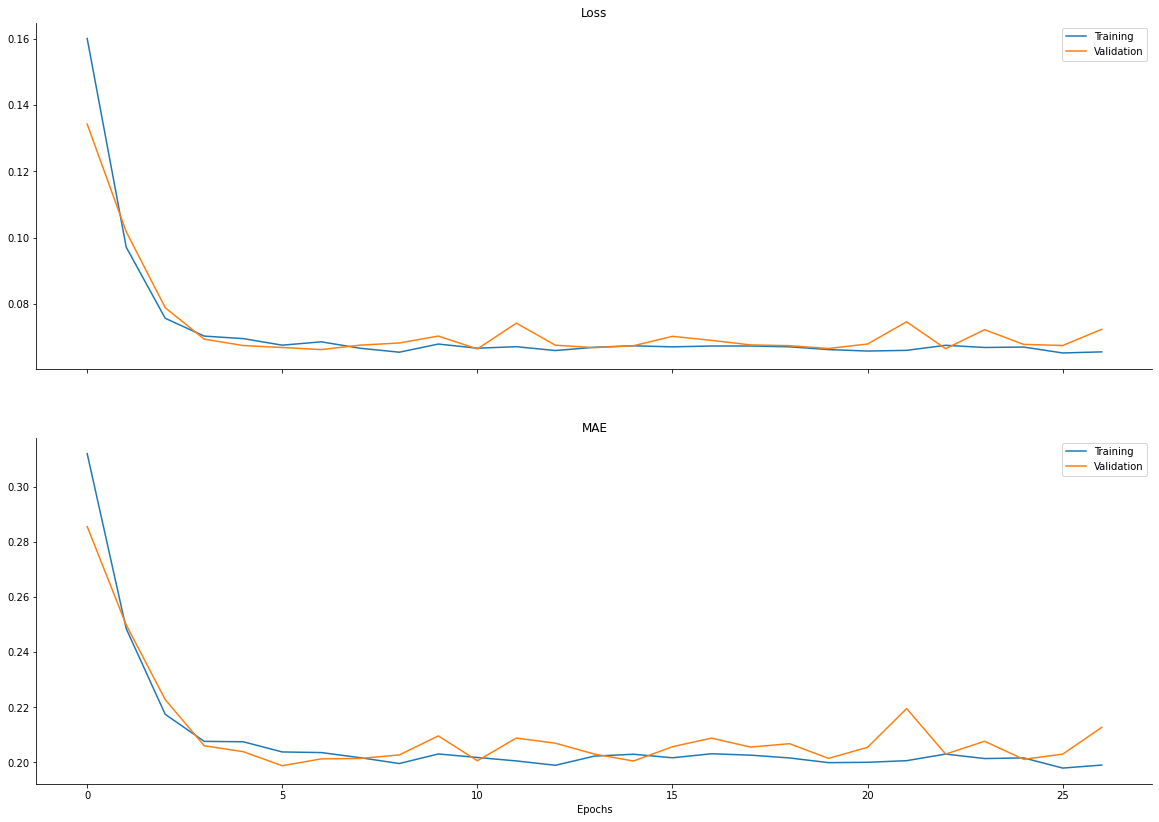

In [45]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [46]:
model.load_weights('model.h5')
(mse, mae) = model.evaluate(test_ds)
print('mean squared error = ' + str(mse))
print('mean absolute error = ' + str(mae))

23/23 [==============================] - 0s 21ms/step - loss: 0.0641 - mae: 0.1933
mean squared error = 0.06411194056272507
mean absolute error = 0.1932550072669983


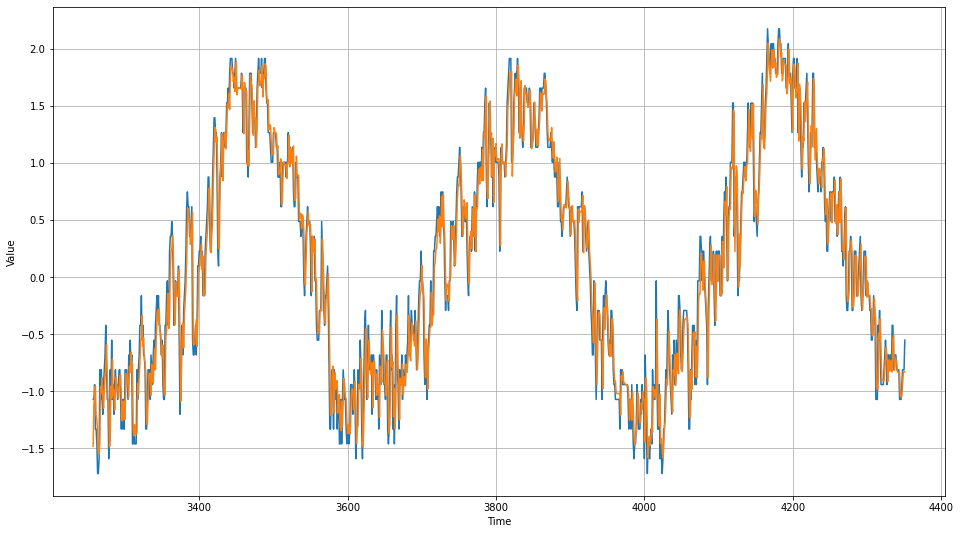

In [47]:
time_test = np.array(test_df.index)

forecast=[]
times = range(split_index-window_size, len(series)-window_size)
for time in times:
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(16, 9))

plot_series(time_test, x_test)
plot_series(time_test, results)

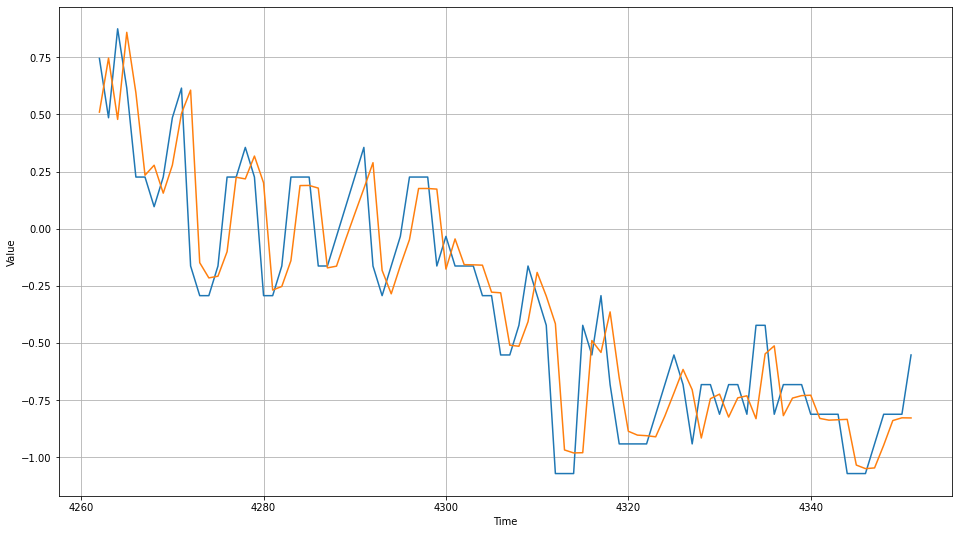

In [48]:
plt.figure(figsize=(16, 9))

plot_series(time_test[-90:], x_test[-90:])
plot_series(time_test[-90:], results[-90:])

In [49]:
results = model.predict(test_ds)

m = tf.keras.metrics.MeanAbsoluteError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mae = m.result().numpy()

m = tf.keras.metrics.MeanSquaredError()
m.update_state(unscale_series(x_test[window_size:]), unscale_series(results))
mse = m.result().numpy()

report.loc[len(report)] = ['LSTM', mae, mse]

# Additional inputs

Given events as additional input, can we improve our results?

In [50]:
df = original_df.copy(deep=True)
df = df[df['Date'] > '2004-01-31'].reset_index(drop=True)
df.drop(['Date', 'Max TemperatureC', 'Min TemperatureC',
       'Dew PointC', 'MeanDew PointC', 'Min DewpointC', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressurehPa',
       ' Mean Sea Level PressurehPa', ' Min Sea Level PressurehPa',
       ' Max VisibilityKm', ' Mean VisibilityKm', ' Min VisibilitykM',
       ' Max Wind SpeedKm/h', ' Mean Wind SpeedKm/h', ' Max Gust SpeedKm/h',
       'Precipitationmm', ' CloudCover', 'WindDirDegrees'], axis='columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Mean TemperatureC  4352 non-null   float64
 1    Events            1123 non-null   object 
dtypes: float64(1), object(1)
memory usage: 68.1+ KB


In [51]:
df[' Events'] = df[' Events'].fillna('Nada') # Nothing happened on most days

In [52]:
df = pd.get_dummies(df, prefix='event', columns=[' Events'])

In [53]:
from sklearn.model_selection import train_test_split

train_df = df[:split_index]
train_df, val_df = train_test_split(train_df, test_size=0.2, shuffle=False)
test_df = df[split_index:]

train_mean = train_df['Mean TemperatureC'].mean()
train_std = train_df['Mean TemperatureC'].std()

train_df['Mean TemperatureC'] = (train_df['Mean TemperatureC'] - train_mean) / train_std
val_df['Mean TemperatureC'] = (val_df['Mean TemperatureC'] - train_mean) / train_std
test_df['Mean TemperatureC'] = (test_df['Mean TemperatureC'] - train_mean) / train_std

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [54]:
def get_m_dataset(series, window_size, batch_size, shuffle=False, cache=False):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.map(lambda window: (window[:-1:], window[-1][:1]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1024)
  ds = ds.batch(batch_size)
  if cache:
    ds = ds.cache()
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds

In [55]:
x_train = np.array(train_df, dtype=np.float32)
train_ds = get_m_dataset(x_train, window_size, batch_size, shuffle=True)
x_val = np.array(val_df, dtype=np.float32)
val_ds = get_m_dataset(x_val, window_size, batch_size, shuffle=False, cache=True)
x_test = np.array(test_df, dtype=np.float32)
test_ds = get_m_dataset(x_test, window_size, batch_size, shuffle=False, cache=True)

In [56]:
# for element in test_ds.take(1):
#   print(element)

In [57]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
random.seed(seed)

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Model, Input

input1 = Input(shape=[window_size, 14])
x = LSTM(512, return_sequences=True)(input1)
x = LSTM(256)(x)
x = Dense(64, activation='swish')(x)
out = Dense(1)(x)

model = Model(inputs=[input1], outputs=[out])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', 
              metrics=['mae'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 366, 14)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 366, 512)          1079296   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,883,265
Trainable params: 1,883,265
Non-trainable params: 0
_________________________________________________________________


In [58]:
filepath = 'model.h5'

mc = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=0, save_weights_only=True, 
                                        monitor='val_loss', mode='auto', save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

history = model.fit(train_ds, epochs=500, verbose=2, callbacks=[es, mc], validation_data=val_ds)

Epoch 1/500
70/70 - 5s - loss: 0.1635 - mae: 0.3148 - val_loss: 0.1344 - val_mae: 0.2852
Epoch 2/500
70/70 - 4s - loss: 0.1002 - mae: 0.2534 - val_loss: 0.1031 - val_mae: 0.2501
Epoch 3/500
70/70 - 4s - loss: 0.0750 - mae: 0.2161 - val_loss: 0.0794 - val_mae: 0.2284
Epoch 4/500
70/70 - 4s - loss: 0.0677 - mae: 0.2031 - val_loss: 0.0685 - val_mae: 0.2038
Epoch 5/500
70/70 - 4s - loss: 0.0657 - mae: 0.1997 - val_loss: 0.0675 - val_mae: 0.2065
Epoch 6/500
70/70 - 4s - loss: 0.0649 - mae: 0.1982 - val_loss: 0.0650 - val_mae: 0.2010
Epoch 7/500
70/70 - 4s - loss: 0.0645 - mae: 0.1987 - val_loss: 0.0638 - val_mae: 0.1970
Epoch 8/500
70/70 - 4s - loss: 0.0635 - mae: 0.1961 - val_loss: 0.0675 - val_mae: 0.2045
Epoch 9/500
70/70 - 4s - loss: 0.0645 - mae: 0.1988 - val_loss: 0.0680 - val_mae: 0.2077
Epoch 10/500
70/70 - 4s - loss: 0.0625 - mae: 0.1945 - val_loss: 0.0671 - val_mae: 0.2036
Epoch 11/500
70/70 - 4s - loss: 0.0627 - mae: 0.1945 - val_loss: 0.0630 - val_mae: 0.1957
Epoch 12/500
70/70 

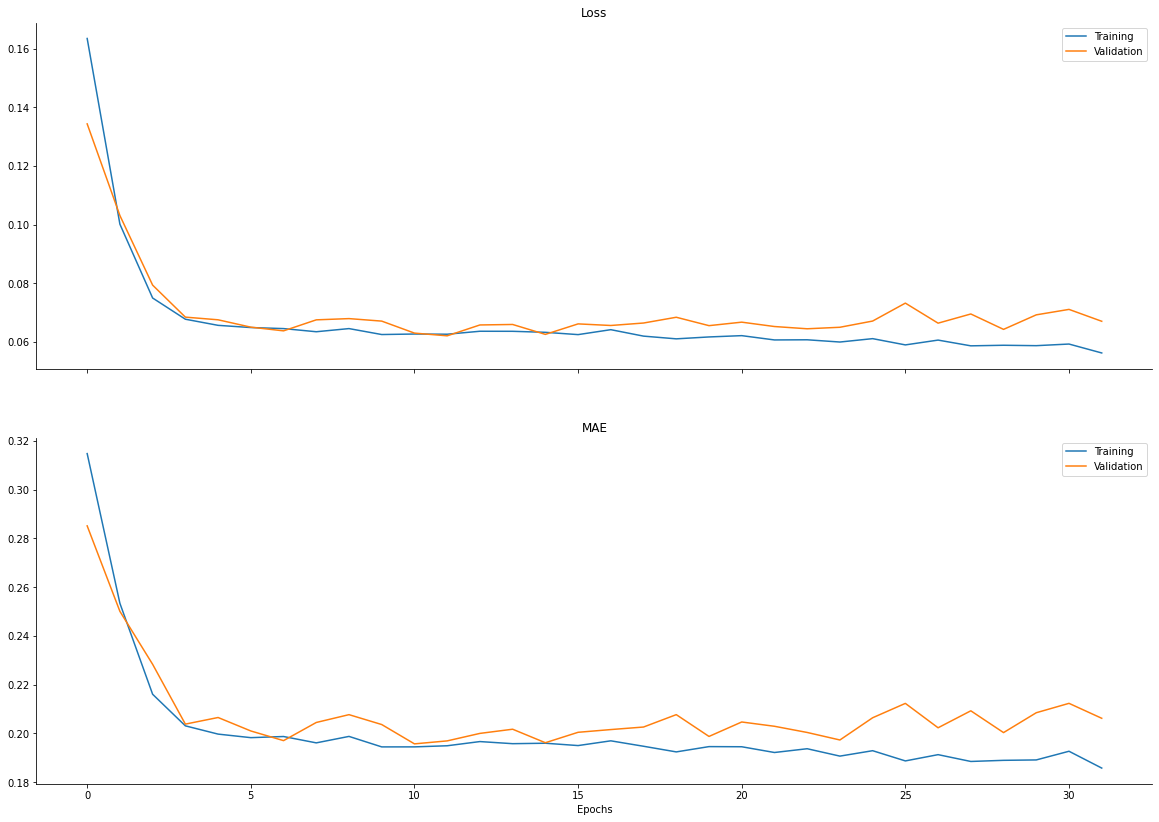

In [59]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['mae'], label='Training')
ax2.plot(history['val_mae'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('MAE')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [60]:
def unscale_series2(s):
  return (s * train_std) +  train_mean

In [61]:
model.load_weights('model.h5')
(mse, mae) = model.evaluate(test_ds)
print('mean squared error = ' + str(mse))
print('mean absolute error = ' + str(mae))

results = model.predict(test_ds)

m = tf.keras.metrics.MeanAbsoluteError()
m.update_state(unscale_series2(y_true[window_size:]), unscale_series2(results))
mae = m.result().numpy()

m = tf.keras.metrics.MeanSquaredError()
m.update_state(unscale_series2(y_true[window_size:]), unscale_series2(results))
mse = m.result().numpy()

report.loc[len(report)] = ['LSTM - Events', mae, mse]

23/23 [==============================] - 0s 21ms/step - loss: 0.0649 - mae: 0.1992
mean squared error = 0.0648735985159874
mean absolute error = 0.19920358061790466


# Summary

In [62]:
print(report)

           Model       MAE       MSE
0       Baseline  1.500686  4.181070
1            DNN  1.973037  5.803751
2      SimpleRNN  1.561302  4.010463
3            GRU  1.504707  3.810984
4           LSTM  1.488877  3.805354
5  LSTM - Events  1.534706  3.850563


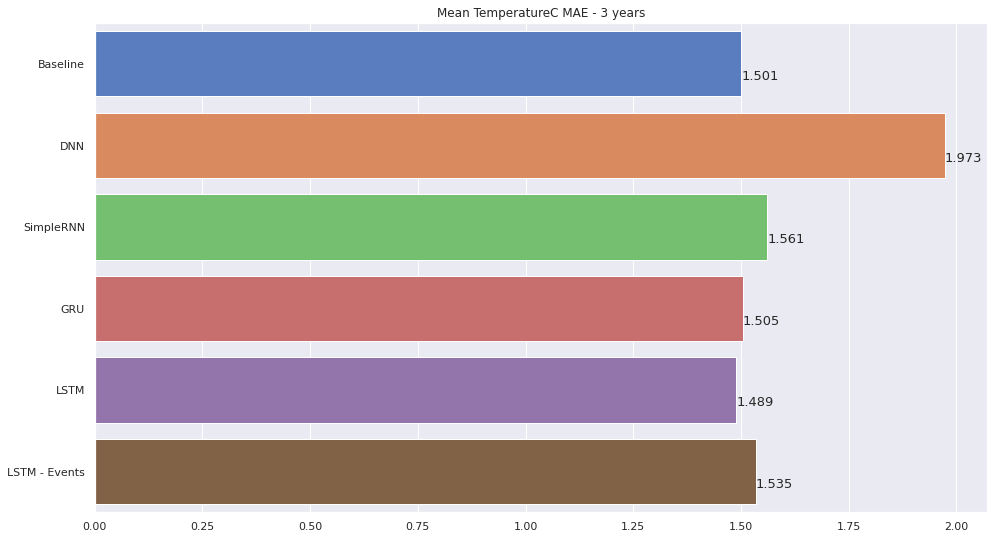

In [63]:
sns.set(rc={'figure.figsize':(16,9)})
ax = sns.barplot(report.MAE, report.Model, orient='h', palette=sns.color_palette("muted"))

for i, mae in enumerate(report.MAE):
    ax.text(mae, i+0.2, f'{mae:.3f}', fontsize=13)
plt.title(f'Mean TemperatureC MAE - 3 years')
plt.xlabel('')
plt.ylabel('')
plt.show()

30 Day Window:

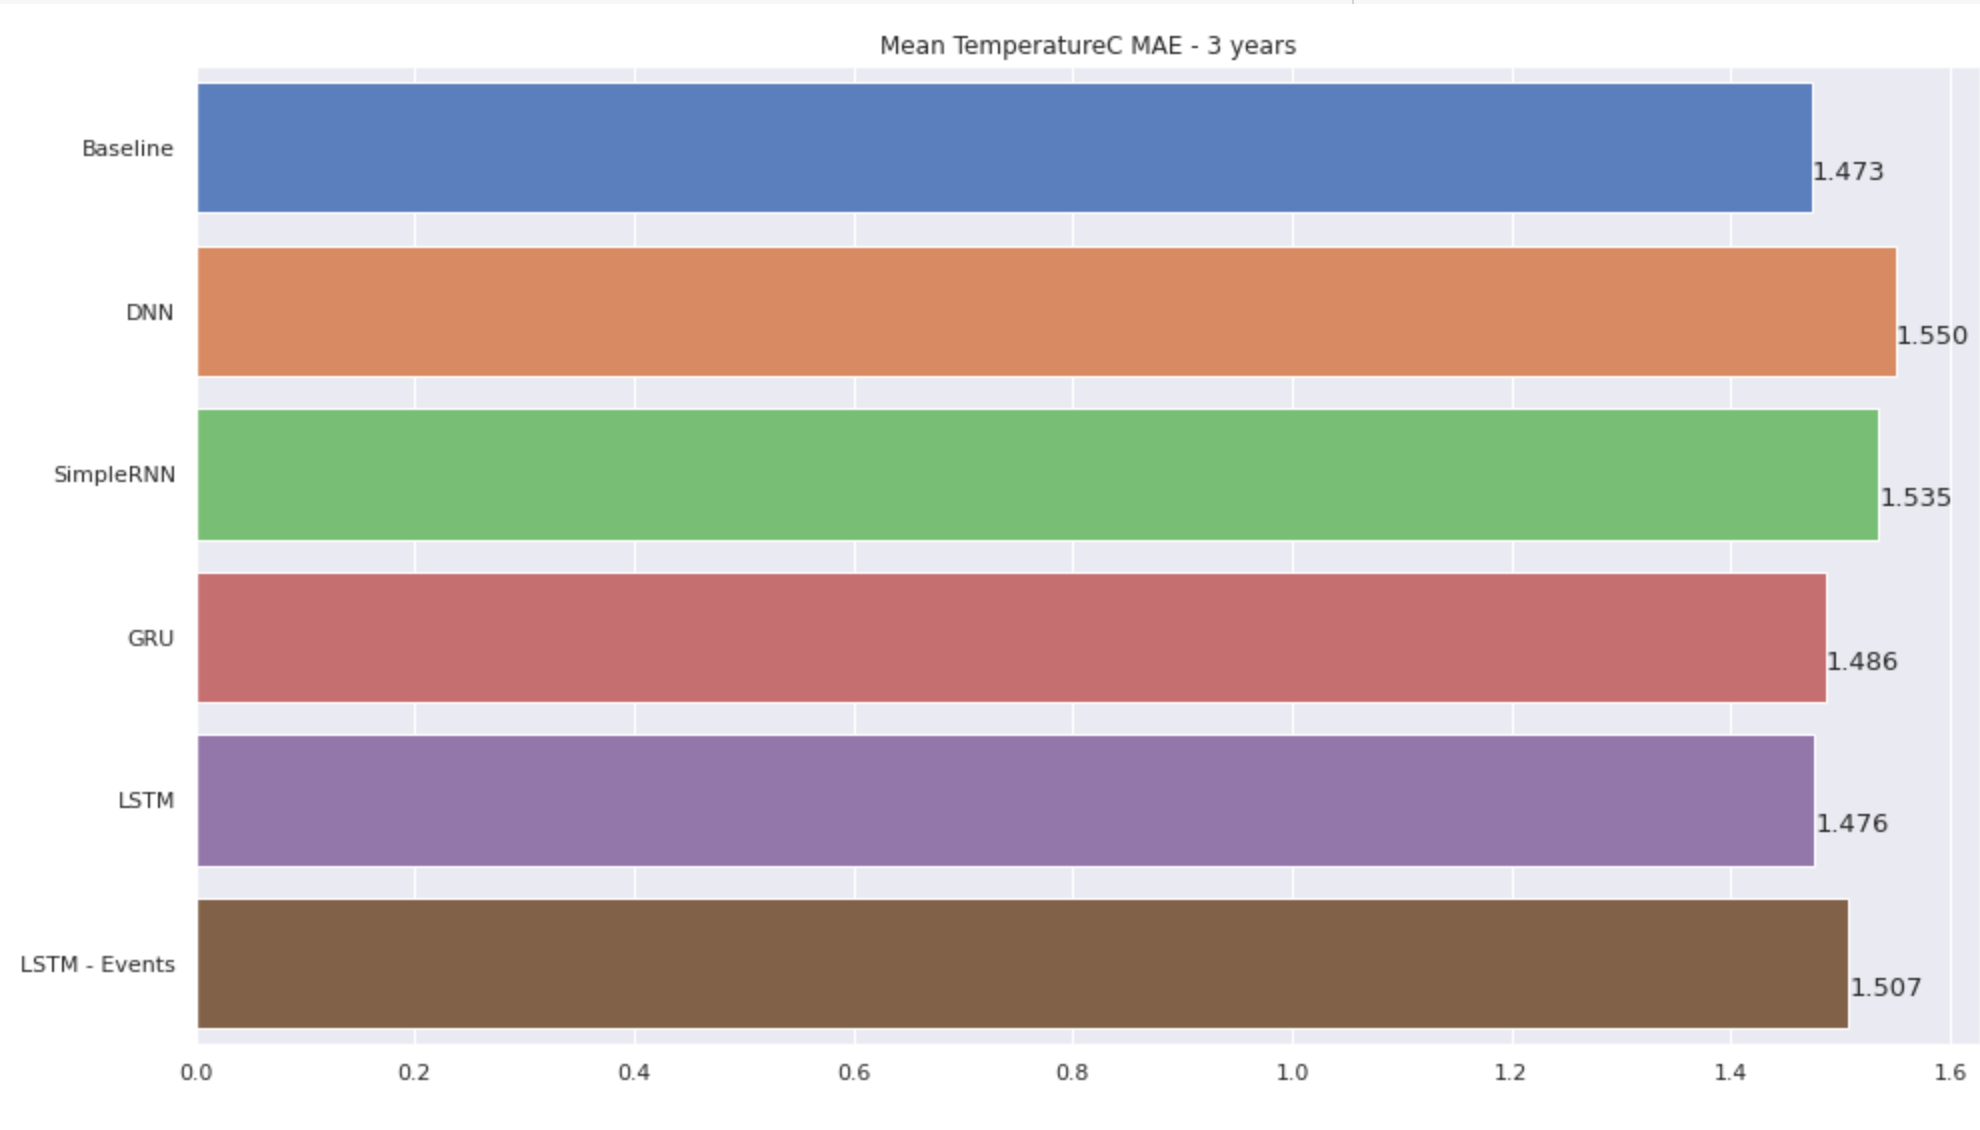

366 Day Window:

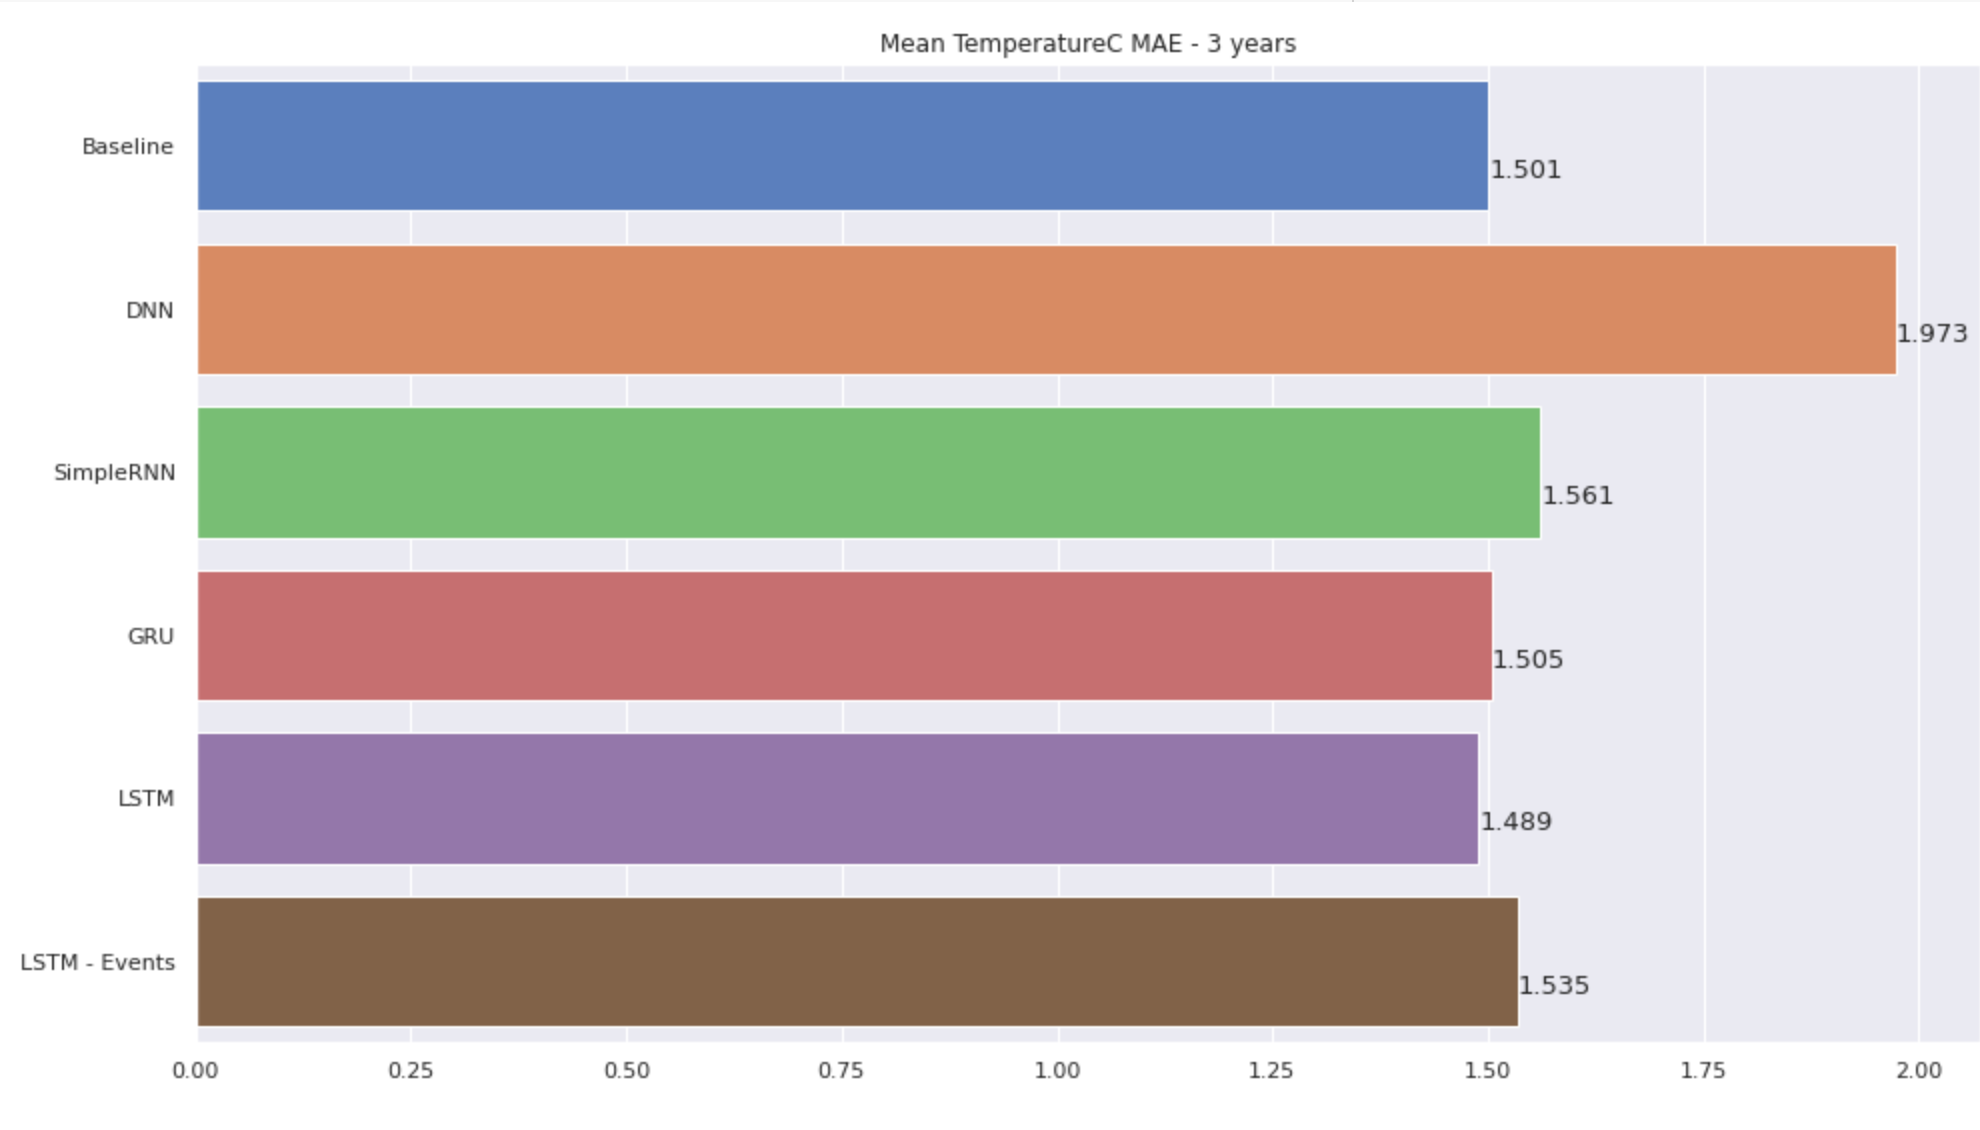